## Functions Required to Solve Simple Elliptic Equation with Dirichlet Conditions Using Finite Element Method
In this module, we will solve the equation

\begin{align}
-\frac{d}{dx} & \left(q(x) \frac{d u(x)}{dx} \right)  = f(x) \qquad
\Longleftrightarrow \qquad         &&
-\frac{d q(x)}{dx} \frac{d u(x)}{dx} - q(x)\frac{d^2 u(x)}{d^2x} = f(x)\\
& u(a) = u0,  && \qquad \qquad u(a) = u0, \\
& u(b) = u1  && \qquad \qquad u(b) = u1
\end{align}

Since this article will try to explain the functions and method of finite element solution for this problem, we will occassionally throw in diagrams where necessary so we'll embed images using markdown embedding syntax

The first step in solving ODE/PDE using finite element method is to formulate the _weak form_ of the problem. For the elliptic equation above, we do this as follows:  
For a _test_ function $v \in H^1_0(\Omega) = \{ v \in L^2(\Omega) : v'\in L(\Omega), v|_{\partial \Omega} = 0 \}$ where $\Omega = [a,b]$,
\begin{align}
\int_{\Omega}-\frac{d}{dx} \left(q(x) \frac{d u(x)}{dx} \right)v(x) dx  &= \int_{\Omega} f(x)v(x) dx\\
-q(x)u'(x)v(x) |_{\partial \Omega} + \int_{\Omega} q(x)u'(x)v'(x)dx &=  \int_{\Omega} f(x)v(x) dx\\
 \int_{\Omega} q(x)u'(x)v'(x)dx &=  \int_{\Omega} f(x)v(x) dx\\
\end{align}

$u$ which solves the given differential equation is infinite dimensional. However, we approximate $u$ with a  $u^h$ where 
$$
u^h(x) = \sum_{i=1}^n c_i \phi_i(x)
$$
and 
$
\phi_1, \phi_2, \cdots, \phi_n
$
are finite number of basis functons which could be _linear, quadratic, cubic, etc_ over the compact domain $\Omega$.

Plugging $u^h$ into the weak form and also approximating $u$ by $u^h = \phi_i$ for $i = 1,2,\cdots,n$, we get

\begin{align}
 \int_{\Omega} q(x)u'(x)v'(x)dx &=  \int_{\Omega} f(x)v(x) dx\\
 \int_{\Omega} q(x)\left( \sum_{j=1}^n c_j \phi_j'(x) \right) \phi_i'(x)dx &=  \int_{\Omega} f(x)\phi_i(x) dx, \qquad i = 1,2,3,\cdots,n\\
 \sum_{j=1}^n \left(\int_{\Omega} q(x)\phi_j'(x) \phi_i'(x)dx \right)c_j  &=  \int_{\Omega} f(x)\phi_i(x) dx, \qquad i = 1,2,3,\cdots,n\\
\end{align}

The integral
$
A_{ij} = \int_{\Omega} q(x)\phi_j'(x) \phi_i'(x)dx
$
is called the bilinear form.

If we write out the last equation explicitly for each $i$, we would get an $n\times n$ system of equations in $c_j$'s. Below, we have $6$ python functions that computes the bilinear form and the RHS over each element:  


oned_mesh = generates computational nodes on $\Omega$ and their corresponding indices  
oned_gauss = stores Gaussian quadrature nodes (on $[-1,1]$, the reference element) and weights for approximating the bilinear form  
oned_shape = evaluates $q(x)$ (called kernel in the code), $\phi_j$ (and it's 1st and 2nd derivatives p_x, p_xx) on the Gaussian nodes and on each of the the physical elements   
oned_linear = computes the right hand side integral for each $i = 1, 2, \cdots, n$.  
oned_bilinear = computes the bilinear form $\int_{\Omega} q(x)\phi_j'(x) \phi_i'(x)dx$ for each $i,j$


### oned_mesh

The function oned_mesh generates finite elements nodes and the connectivity matrix e_conn which is an $n$ by $m$ indices matrix where $n$ is the number of elements and $m$ is the number of nodes per elements. For linear bases functions $m = 2$, for quadratic $m = 3$, for cubic $m = 4$ and it continues in that manner

In [1]:
#!/usr/bin/env python3
"""
Module for solving one dimensional finite element problems
"""

import numpy as np

def oned_mesh(x_min, x_max, n_elements, element_type):
    """
    Description: Construct a one dimensional finite element mesh. 

    Usage: x, e_conn = oned_fem_mesh(x_min, x_max, n_elements, element_type)

    Inputs:

        x_min: double, left interval endpoint

        x_max: double, right interval endpoint

        n_elements: int, number of elements

        element_type: str, polynomial order 'linear', 'quadratic', or 'cubic'


    Outputs: 

        x: double, vector of finite element nodes

        e_conn: int, (n_elements, n_dof) connectivity matrix whose ith row
           contains the indices of the nodes x(i) contained in the ith element

    Last modified: 

        02/05/2021, Hans-Werner van Wyk

    """
    if element_type == 'linear':
        # Define mesh nodes
        x = np.linspace(x_min,x_max,n_elements+1);
        
        # Define connectivity matrix
        e_conn = (np.arange(n_elements),np.arange(1,n_elements+1))
        e_conn = np.stack(e_conn,axis=1)
        
    elif element_type == 'quadratic':
        # Define the mesh nodes
        x = np.linspace(x_min, x_max, 2*n_elements + 1)
        
        # Define the connectivity matrix
        e_conn = (np.arange(0,2*n_elements-1,2),
                  np.arange(1,2*n_elements,2),
                  np.arange(2,2*n_elements+1,2))
        e_conn = np.stack(e_conn,axis=1)
        
    elif element_type == 'cubic':
        # Define the mesh nodes
        x = np.linspace(x_min,x_max,3*n_elements+1)
        
        # Define the connectivity matrix
        e_conn = (np.arange(0,3*n_elements-2,3),
                  np.arange(1,3*n_elements-1,3),
                  np.arange(2,3*n_elements,3),
                  np.arange(3,3*n_elements+1,3))
        e_conn = np.stack(e_conn,axis=1)
     
    else: 
        # Error
        raise Exception('Use only "linear", "quadratic", '+\
                        'or "cubic" for element_type')
    
    return x,e_conn
    

Suppose $a = -1$ and $b = 1$ and number of elements is $10$ (i.e., there are $11$ nodes). Then

In [2]:
x_min = -1
x_max = 1
n_elements = 5

In [3]:
#
# With linear bases elements
#
element_type = 'linear'
x, e_conn = oned_mesh(x_min, x_max, n_elements, element_type)

In [4]:
x

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [5]:
e_conn

array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5]])

These outputs can be visualized as

![Linear Nodes and Elements](./nodes_and_elements1.png)

In [6]:
#
# With quadratic bases elements
#
element_type = 'quadratic'
x, e_conn = oned_mesh(x_min, x_max, n_elements, element_type)

In [7]:
x

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [8]:
e_conn

array([[ 0,  1,  2],
       [ 2,  3,  4],
       [ 4,  5,  6],
       [ 6,  7,  8],
       [ 8,  9, 10]])

Notice that we still have $10$ elements but the number of nodes have changed to accommodate for the number of points needed to compute each basis function over an element. Two points are needed to compute a linear function, three points are need to compute quadratic function, etc.
Again, we visualize as

![Quadratic Nodes and Elements](./nodes_and_elements2.png)

Cubic bases functions follow similarly

In [9]:
#
# With cubic bases elements
#
element_type = 'cubic'
x, e_conn = oned_mesh(x_min, x_max, n_elements, element_type)

In [10]:
x

array([-1.        , -0.86666667, -0.73333333, -0.6       , -0.46666667,
       -0.33333333, -0.2       , -0.06666667,  0.06666667,  0.2       ,
        0.33333333,  0.46666667,  0.6       ,  0.73333333,  0.86666667,
        1.        ])

In [11]:
e_conn

array([[ 0,  1,  2,  3],
       [ 3,  4,  5,  6],
       [ 6,  7,  8,  9],
       [ 9, 10, 11, 12],
       [12, 13, 14, 15]])

Notice that in each case ('linear', 'quadratic', 'cubic'),  
total # of nodes = (n_dof * n_elements) + 1  
where n_dof is the degree of freedom (i.e., # of points required to compute a basis function over each element: n_dof = 2 for linear, 3 for quadratic and 4 for cubic bases) and n_elements is the number of elements.  
We could draw a numbered line representation for cubic elements just like we did for linear and quadratic, but hopefully, we understand the concept clearly from those of linear and quadratic as shown previously.

### oned_gauss

oned_gauss function takes 'rule' as input and returns a vector of Gaussian points (r) in $[-1,1]$ and a vector of Gaussian weights (w) in $[-1,1]$. So
$$
\int_{-1}^1 f(x)dx \approx w_0 f(r_0) + w_1 f(r_1) + w_2 f(r_2) + \cdots + w_{n-1} f(r_{n-1})
$$
assuming we have have chosen rule $=n$. In this case, the integral would be exact (accurate) up to degree $2n-1$ polynomial approximation of $f$.  
Gaussian points and weights are pre-computed and oned_gauss simply records them for call and use as can be clearly seen from the function definition.

A complete and illustrative example on mathematics of the Gaussian Quadrature Rule and how the Gaussian points and weights are derived can be found here
[Gaussian Quadrature Rule](http://webhome.auburn.edu/~cae0027/resources/notes/gauss-quadrature-rule.pdf)
.


In [12]:
# Reset element type to quadratic for illustration purposes
#
element_type = 'quadratic'
x, e_conn = oned_mesh(x_min, x_max, n_elements, element_type)

In [13]:
def oned_gauss(rule):
    """
    Calculate Gauss integration points on (-1,1)

    
    Inputs: 
    
        rule: int, number of Gauss points (between 1 and 11). The precision of
            the Gauss rule is 2*rule - 1
            
            Int[-1,1] f(x) dx ~= sum_{i=1}^rule wi*f(ri)
        
    Outputs:
    
        r: double, (rule,) vector of Gauss points in (-1,1]
        
        w: double, (rule,) vector of Gauss weights
    """

    r = np.zeros(rule)
    w = np.zeros(rule)

    if rule == 1:      # up to order 1 polynomials exact
        r[0] = 0
        w[0] = 2
        
    elif rule == 2:   # up to order 3 polynomials exact
        r[0] =-1.0 / np.sqrt(3.0);
        r[1] =-r[0];
        w[0] = 1.0;
        w[1] = 1.0;
        
    elif rule == 3:  # up to order 5 polynomials exact
        r[0] =-np.sqrt(3.0/5.0);
        r[1] = 0.0;
        r[2] =-r[0];
        w[0] = 5.0 / 9.0;
        w[1] = 8.0 / 9.0;
        w[2] = w[0];
        
    elif rule == 4:  # up to order 7 polynomials exact
        r[0] =-np.sqrt((3.0+2.0*np.sqrt(6.0/5.0))/7.0);
        r[1] =-np.sqrt((3.0-2.0*np.sqrt(6.0/5.0))/7.0);
        r[2] =-r[1];
        r[3] =-r[0];
        w[0] = 0.5 - 1.0 / ( 6.0 * np.sqrt(6.0/5.0) );
        w[1] = 0.5 + 1.0 / ( 6.0 * np.sqrt(6.0/5.0) );
        w[2] = w[1];
        w[3] = w[0];
        
    elif rule == 5:  # up to order 9 polynomials exact
        r[0] =-np.sqrt(5.0+4.0*np.sqrt(5.0/14.0)) / 3.0;
        r[1] =-np.sqrt(5.0-4.0*np.sqrt(5.0/14.0)) / 3.0;
        r[2] = 0.0;
        r[3] =-r[1];
        r[4] =-r[0];
        w[0] = 161.0/450.0-13.0/(180.*np.sqrt(5.0/14.0));
        w[1] = 161.0/450.0+13.0/(180.*np.sqrt(5.0/14.0));
        w[2] = 128.0/225.0;
        w[3] = w[1];
        w[4] = w[0];
        
    elif rule == 6:
        r[0] = -0.2386191860831969;
        r[1] = -0.6612093864662645;
        r[2] = -0.9324695142031521;
        r[3] = - r[0];
        r[4] = - r[1];
        r[5] = - r[2];
        w[0] = 0.4679139345726910;
        w[1] = 0.3607615730481386;
        w[2] = 0.1713244923791704;
        w[3] = w[0];
        w[4] = w[1];
        w[5] = w[2];
        
    elif rule == 7:
        r[0] = -0.9491079123427585;
        r[1] = -0.7415311855993945;
        r[2] = -0.4058451513773972;
        r[3] =  0.0000000000000000;
        r[4] = - r[2];
        r[5] = - r[1];
        r[6] = - r[0];
        w[0] = 0.1294849661688697;
        w[1] = 0.2797053914892766;
        w[2] = 0.3818300505051189;
        w[3] = 0.4179591836734694;
        w[4] = w[2];
        w[5] = w[1];
        w[6] = w[0];
        
    elif rule == 8:
        r[0] = -0.9602898564975363;
        r[1] = -0.7966664774136267;
        r[2] = -0.5255324099163290;
        r[3] = -0.1834346424956498;
        r[4] = - r[3];
        r[5] = - r[2];
        r[6] = - r[1];
        r[7] = - r[0];
        w[0] = 0.1012285362903763;
        w[1] = 0.2223810344533745;
        w[2] = 0.3137066458778873;
        w[3] = 0.3626837833783620;
        w[4] = w[3];
        w[5] = w[2];
        w[6] = w[1];
        w[7] = w[0];

    elif rule == 9:
        r[0] = -0.9681602395076261;
        r[1] = -0.8360311073266358;
        r[2] = -0.6133714327005904;
        r[3] = -0.3242534234038089;
        r[4] =  0.0000000000000000;
        r[5] = - r[3];
        r[6] = - r[2];
        r[7] = - r[1];
        r[8] = - r[0];
        w[0] = 0.0812743883615744;
        w[1] = 0.1806481606948574;
        w[2] = 0.2606106964029354;
        w[3] = 0.3123470770400029;
        w[4] = 0.3302393550012598;
        w[5] = w[3];
        w[6] = w[2];
        w[7] = w[1];
        w[8] = w[0];
      
    elif rule == 10:
        r[0] = -0.9739065285171717;
        r[1] = -0.8650633666889845;
        r[2] = -0.6794095682990244;
        r[3] = -0.4333953941292472;
        r[4] = -0.1488743389816312;
        r[5] = - r[4];
        r[6] = - r[3];
        r[7] = - r[2];
        r[8] = - r[1];
        r[9] = - r[0];
        w[0] = 0.0666713443086881;
        w[1] = 0.1494513491505806;
        w[2] = 0.2190863625159820;
        w[3] = 0.2692667193099963;
        w[4] = 0.2955242247147529;
        w[5] = w[4];
        w[6] = w[3];
        w[7] = w[2];
        w[8] = w[1];
        w[9] = w[0];

    elif rule == 11:
        r[0] = -0.9782286581460570;
        r[1] = -0.8870625997680953;
        r[2] = -0.7301520055740494;
        r[3] = -0.5190961292068118;
        r[4] = -0.2695431559523450;
        r[5] =  0.0000000000000000;
        r[6] = - r[4];
        r[7] = - r[3];
        r[8] = - r[2];
        r[9] = - r[1];
        r[10] = - r[0];
        w[0] = 0.0556685671161737;
        w[1] = 0.1255803694649046;
        w[2] = 0.1862902109277343;
        w[3] = 0.2331937645919905;
        w[4] = 0.2628045445102467;
        w[5] = 0.2729250867779006;
        w[6] = w[4];
        w[7] = w[3];
        w[8] = w[2];
        w[9] = w[1];
        w[10] = w[0];

    else:
        raise Exception('Quadrature rule not supported')
        #Return computed quantities
        
    return r,w

In [14]:
r,w = oned_gauss(5)

In [15]:
r

array([-0.90617985, -0.53846931,  0.        ,  0.53846931,  0.90617985])

$r$ is computed on $[-1,1]$.

In [16]:
w

array([0.23692689, 0.47862867, 0.56888889, 0.47862867, 0.23692689])

$w$ is computed on $[-1,1]$.

###  oned_shape

To apply the Gaussian quadrature rule to the integral 
$
\int_a^b f(x)dx
$,
we make the following transformation
$$ 
x = \frac{b-a}{2}r + \frac{b+a}{2} 
$$
which is gotten by finding the parametric line between $(-1,a)$ and $(1,b)$. Thus,

\begin{align}
\int_{a}^b f(x)dx &\approx \frac{b-a}{2} \int_{-1}^1 f \left(\frac{b-a}{2}r + \frac{b+a}{2} \right)dr\\
                  &= \frac{b-a}{2} \left(w_0 f(x_0) + w_1 f(x_1) + w_2 f(x_2) + \cdots + w_{n-1} f(x_{n-1}) \right)
\end{align}
where 
$
x_i = \frac{b-a}{2}r_i + \frac{b+a}{2} 
$
for $i = 0,1,2,\cdots,n-1$. Again, we have assumed rule $= n$ and for this, the integral is exact up to a polynomial of degree $2n-1$ approximation of $f$. i.e.,
$$
f(x) \approx a_0 + a_1x + a_2x^2 + \cdots + a_{2n-1}x^{2n-1}
$$

$\frac{b-a}{2} =$ Jacobian of the transformation from $x$ to $r$  
$w = (w_0, w_1,\cdots, w_{2n-1}) =$ Gauss weights on the reference element $[-1,1]$   
$w = (\frac{b-a}{2}w_0, \frac{b-a}{2}w_1,\cdots, \frac{b-a}{2}w_{2n-1}) =$ Gauss weights on the physical element. In oned_shape, $w\_g := w$.     
$r = (r_0, r_1,\cdots, r_{2n-1}) =$ Gauss points/nodes on the reference element $[-1,1]$  
$x = (x_0, x_1,\cdots, x_{2n-1}) =$ Gauss points/nodes on the physical element. In oned_shape, $x\_g := x$


In the function oned_shape, $x$ is a vector of nodal values indexed by each row of

In [17]:
e_conn

array([[ 0,  1,  2],
       [ 2,  3,  4],
       [ 4,  5,  6],
       [ 6,  7,  8],
       [ 8,  9, 10]])

assuming element_type is 'cubic'. So the call of oned_shape must loop over the total number of elements to get each $x$ which now represents .


In [18]:
def oned_shape(x,r,w):
    """
    computes test functions and derivatives for a Lagrange C0 element given
    element coordinates and Gauss points. (assumes all nodes are uniformly 
    distributed in the element).


    Usage:    x_g,w_g,phi,p_x,p_xx = oned_shape(x,r,w)

    Inputs:     
    
        x: double, coordinates of the element nodes
                 
        r: double, coordinates of Gauss points in (-1,1)
        
        w: double, Gauss weights associated with r
        
        
    Outputs:

        x_g: double, coordinates of Gauss points in the element
                 
        w_g: double, Gauss weights scaled by the element Jacobian
                 
        phi: double, value of element shape functions at x_g
        
        p_x: double, first spatial derivatives of phi
        
        p_xx: double, second spatial derivatives of phi
    
    
    Modified: 
    
        02/05/2021, Hans-Werner van Wyk 
    """
    n_dof = len(x)  # number of dofs
    n_g = len(r)  # number of Gaussian quadrature points
    
    if n_dof==2:
        # Transform coordinates for linear elements
        c0 = ( x[-1]-x[0] )/2
        c1 = ( x[-1]+x[0] )/2
    
        # Gaussian nodes
        x_g = c0*r + c1

        # Evaluate basis function at Gauss points
        phi = np.empty((n_g,n_dof))
        phi[:,1] = ( 1+r )/2
        phi[:,0] = ( 1-r )/2
        
        # Evaluate first derivative at Gauss points
        p_x = np.empty((n_g,n_dof))
        p_x[:,1] = 0.5*np.ones(n_g)/c0
        p_x[:,0] =-p_x[:,1]

        # Jacobian
        djac = c0
    
        # Compute physical weights
        w_g = djac*w

        # Second derivative 
        p_xx = np.zeros((n_g,n_dof))
    
    elif n_dof==3:
        
        # Transform coordinates for quadratic elements
        c0 = ( x[-1]-x[0] )/2
        c1 = ( x[-1]+x[0] )/2
        
        # Physical Gauss nodes
        x_g = c0*r + c1

        # defined backwards to help Matlab create the proper sized array
        phi = np.empty((n_g,n_dof))
        phi[:,2] = .5*r*( r+1 )
        phi[:,1] =-( r+1 )*( r-1 )
        phi[:,0] = .5*r*( r-1 )

        # First derivative 
        p_x = np.empty((n_g,n_dof))
        p_x[:,2] = ( r+.5 )/c0
        p_x[:,1] =-2*r/c0
        p_x[:,0] = ( r-.5 )/c0

        # Jacobian 
        djac = c0

        # Gaussian weight on physical element
        w_g = djac*w
        
        # Second derivative
        p_xx = np.empty((n_g,n_dof))
        p_xx[:,2] = np.ones(n_g)/c0**2
        p_xx[:,1] =-2*p_xx[:,2]
        p_xx[:,0] = p_xx[:,2]

    elif n_dof==4:
        # Transform coordinates for (nonconforming) cubic elements
        c0 = ( x[-1]-x[0] )/2
        c1 = ( x[-1]+x[0] )/2

        x_g = c0*r + c1

        r2  = r*r
        r3  = r*r2

        # defined backwards to help Matlab create the proper sized array
        phi = np.zeros((n_g,n_dof))
        phi[:,3] =  9*( r3+r2-r/9-1/9 )/16
        phi[:,2] =-27*( r3+r2/3-r-1/3 )/16
        phi[:,1] = 27*( r3-r2/3-r+1/3 )/16
        phi[:,0] =- 9*( r3-r2-r/9+1/9 )/16

        # Derivative on reference element
        p_r = np.zeros((n_g,n_dof))
        p_r[:,3] =  9*( 3*r2+2*r-1/9 )/16
        p_r[:,2] =-27*( 3*r2+2*r/3-1 )/16
        p_r[:,1] = 27*( 3*r2-2*r/3-1 )/16
        p_r[:,0] =- 9*( 3*r2-2*r-1/9 )/16
        
        # Second derivative on reference element
        p_rr = np.zeros((n_g,n_dof))
        p_rr[:,3] =  9*( 6*r+2   )/16
        p_rr[:,2] =-27*( 6*r+2/3 )/16
        p_rr[:,1] = 27*( 6*r-2/3 )/16
        p_rr[:,0] =- 9*( 6*r-2   )/16

        # Jacobian 
        dxdr = p_r.dot(x)
        drdx = 1/dxdr
        
        # Quadrature weights on physical element
        w_g = dxdr*w
        
        # Derivative on physical element
        p_x = np.zeros((n_g,n_dof))
        p_x[:,3] = p_r[:,3]*drdx
        p_x[:,2] = p_r[:,2]*drdx
        p_x[:,1] = p_r[:,1]*drdx
        p_x[:,0] = p_r[:,0]*drdx
        
        # Second derivative on physical element
        p_xx = np.zeros((n_g,n_dof))     
        p_xx[:,3] = p_rr[:,3]*drdx**2
        p_xx[:,2] = p_rr[:,2]*drdx**2
        p_xx[:,1] = p_rr[:,1]*drdx**2
        p_xx[:,0] = p_rr[:,0]*drdx**2
    else:
        raise Exception('Elements higher than cubic not currently supported')
    
    # Return computed quantities
    return x_g, w_g, phi, p_x, p_xx    

Since oned_shape is computed over each element, we print the function returns over the last element for the sake of illutsration

In [19]:
#
# Recompute mesh for this illustration
#
x, e_conn = oned_mesh(x_min, x_max, n_elements, element_type)

In [20]:
#
# Ilustration of how the function is used
for i in range(n_elements):
    y = x[e_conn[i]]
    x_g, w_g, phi, p_x, p_xx  = oned_shape(y,r,w)

In [21]:
x_g

array([0.61876403, 0.69230614, 0.8       , 0.90769386, 0.98123597])

In [22]:
w_g

array([0.04738538, 0.09572573, 0.11377778, 0.09572573, 0.04738538])

In [23]:
phi

array([[ 0.86367088,  0.17883809, -0.04250897],
       [ 0.41420925,  0.7100508 , -0.12426006],
       [-0.        ,  1.        ,  0.        ],
       [-0.12426006,  0.7100508 ,  0.41420925],
       [-0.04250897,  0.17883809,  0.86367088]])

The first column of phi represents the the blue curve (below) evaluated at the Gaussian nodes; the second column, the orange curve; and the third column, the green curve.

![Quadratic Nodes and Elements](./quadratic_elements1.png)

In [24]:
p_x

array([[-7.03089923,  9.06179846, -2.03089923],
       [-5.19234655,  5.3846931 , -0.19234655],
       [-2.5       , -0.        ,  2.5       ],
       [ 0.19234655, -5.3846931 ,  5.19234655],
       [ 2.03089923, -9.06179846,  7.03089923]])

The first column of p_x is the derivative of the blue quadratic curve above evaluated at the Gaussian nodes; the second column, the orange curve; the third column, the green curve

In [25]:
p_xx

array([[ 25., -50.,  25.],
       [ 25., -50.,  25.],
       [ 25., -50.,  25.],
       [ 25., -50.,  25.],
       [ 25., -50.,  25.]])

The first column of p_xx is the derivative of the blue quadratic curve above evaluated at the Gaussian nodes; the second column, the orange curve; the third column, the green curve.  
Clearly, we can see p_xx is constant for each of the curves since they are quadratics.

### oned_linear

oned_linear computes approximation of the integral 
$
\int_{\Omega} f(x)\phi_i(x) dx
$
for each $i$, using Gaussian quadrature rule.  
kernel = f(x_g) where x_g is a vector of Gaussian nodes on the physical element  
w_g = Gaussian weights on the physical element  
test = matrix of size # of gaussian nodes by n_dof representing basis function an element

In [26]:
    
def oned_linear(kernel, test, w_g):
    """
    Compute the one-dimensional local linear form (f,phi)
    
    Inputs:
    
        kernel: double (n_gauss,) kernel evaluated at the Gauss nodes.
        
        test: double, (n_gauss, n_dofs) array of element test functions
            evaluated at the Gauss nodes.
            
        w_g: double, (n_gauss,) Gauss quadrature weights on element.     
        
        
    Output:
    
        L: double, (n_dofs,) vector with entries 
        
            L_i = int_Ke f(x) phi_i(x) dx ~= sum_j w_g(j) f(x_j) phi_i(x_j) 
    """
    b = np.dot(test.T, kernel*w_g)
    return b
    

Since oned_linear loops over the total number of elements, we call the function over the last element for illustration. We will take $f(x) = x^2$ for simplicity.

In [27]:
f = lambda x: x**2
f_g = f(x_g)

In [28]:
oned_linear(f_g,phi,w_g)

array([0.02293333, 0.1728    , 0.0656    ])

These entries correspond to the integral 
$
\int_{\Omega} f(x)\phi_i(x) dx
$
when $\phi_i$ is blue, orange, and green respectively as shown.

![Quadratic Nodes and Elements](./quadratic_elements1.png)

### oned_bilinear

oned_bilinear computes approximation of the integral 
$
\int_{\Omega} q(x)\phi_j'(x) \phi_i'(x) dx
$
for each $i,j$, using Gaussian quadrature rule. Just like the previous functions, oned_bilinear computation is done over an element and then a loop is performed over all possible elements. In the code:

kernel = a vector of $q(x)$ evaluated at the Gauss nodes    
phi = matrix whose columns represent $\phi_j'(x)$ evaluated at the Gauss nodes. For linear shape/hat/basis functions, the matrix has 2 columns; for quadratic, 3 columns; etc.  
test = matrix whose columns represent $\phi_i'(x)$ evaluated at the Gauss nodes. For linear shape/hat/basis functions, the matrix has 2 columns; for quadratic, 3 columns; etc.  
w_g = Gauss weights

For the sake of illustration, we take $q(x) = x$ and retain w_g, phi above. Furthermore, we take test = phi (Galerkin method).

In [29]:
q = lambda x: x

In [30]:
q(x_g)

array([0.61876403, 0.69230614, 0.8       , 0.90769386, 0.98123597])

In [31]:
def oned_bilinear(kernel,phi,test,w_g):
    """
    Compute the local bilinear form (kernel, phi, test)     
    
    
    Inputs:
    
        kernel: double (n_gauss,), kernel function in the integral evaluated at the
            Gauss points.
    
    
        phi: double, (n_gauss,n_dofs) matrix of trial functions evaluated at 
            Gauss points. 
            
            
        test: double, (n_gauss,n_dofs) matrix of test functions evaluated at 
            Gauss points. 
            
        w_g: double, (n_gauss,) Gauss quadrature weights.
        
        
    Output:
    
        B: double, (n_dofs, n_dofs) local blinear form over element Ke with entries
        
            B_ij = int_Ke f(x) phi_j(x) test_i(x) dx 
                 
                 ~= sum_{k} w_g(k) f(x_k) phi_j(x_k) test_i(x_k) 
        
    """
    M = np.dot(np.dot(test.T,np.diag(kernel*w_g)),phi)
    return M
    
    

    

In [32]:
A_loc = oned_bilinear(q(x_g),p_x,p_x,w_g)

In [33]:
A_loc

array([[ 4.        , -4.66666667,  0.66666667],
       [-4.66666667, 10.66666667, -6.        ],
       [ 0.66666667, -6.        ,  5.33333333]])

The output of oned_bilinear, A_loc is the local assembly of the stiffness matrix, A over the specific element.

![Quadratic Nodes and Elements](./quadratic_elements1.png)

Since we ran the code on the last element which is indexed by:

In [34]:
e_conn[-1]

array([ 8,  9, 10])

it follows that index $8$ represents the blue parabola; index $9$, the orange parabola; and index $10$, the green parabola. Thus 

A_loc$_{8,8} = \int_{\Omega} q(x)\phi_8'(x) \phi_8'(x) dx = 4$  
A_loc$_{8,9} = \int_{\Omega} q(x)\phi_8'(x) \phi_9'(x) dx = -4.66666667$  
A_loc$_{8,10} = \int_{\Omega} q(x)\phi_8'(x) \phi_{10}'(x) dx = 0.66666667$  
A_loc$_{9,8} = \int_{\Omega} q(x)\phi_9'(x) \phi_8'(x) dx = -4.66666667$  
A_loc$_{9,9} = \int_{\Omega} q(x)\phi_9'(x) \phi_9'(x) dx = 10.66666667$  
A_loc$_{9,10} = \int_{\Omega} q(x)\phi_9'(x) \phi_{10}'(x) dx = -6$  
A_loc$_{10,8} = \int_{\Omega} q(x)\phi_{10}'(x) \phi_8'(x) dx = 0.66666667$  
A_loc$_{10,9} = \int_{\Omega} q(x)\phi_{10}'(x) \phi_9'(x) dx = -6$  
A_loc$_{10,10} = \int_{\Omega} q(x)\phi_{10}'(x) \phi_{10}'(x) dx = 5.33333333$  

### Coupling the functions to solve specific problems

In [35]:
# Exact solution
ue = lambda x: x**2  + x

In [36]:
# Diffusion coefficient
q = lambda x: 1 + 0.5*x

In [37]:
# Forcing term
f = lambda x: -(2.5 + 2*x)

In [38]:
# Interval end points
a = -1
b = 1

In [39]:
import numpy as np
import scipy
from scipy.sparse import linalg
import matplotlib.pyplot as plt

# Generate the computational mesh
n_elements = 10      # specify number of elements

# Compute nodes and connectivity matrix
x, e_conn = oned_mesh(a,b,n_elements,'linear')

n_nodes = len(x)            # number of nodes
n_dofs = len(e_conn[1,:])   # degrees of freedom per element

# Index to keep track of equation numbers
ide = np.zeros(n_nodes, dtype=int)  # initialize

# Mark Dirichlet nodes by -1
i_dir = [0,n_nodes-1]  # indices of dirichlet nodes
ide[i_dir] = -1        # dirichlet nodes are marked by -1

# Number remaining nodes from 0 to n_equations-1
count = 0
for i in range(n_nodes):
    if ide[i] == 0:
        ide[i] = count
        count = count + 1

n_equations = count   # total number of equations


# Initialize sparse stiffness matrix
nnz = n_elements*n_dofs**2        # estimate the number of non-zero elements

rows = np.zeros(nnz, dtype=int)   # row index
cols = np.zeros(nnz, dtype=int)   # column index
vals = np.zeros(nnz)              # matrix entries

# Initialize the RHS
c = np.zeros(n_equations)

# Assembly
r,w = oned_gauss(11) # Gauss rule accurate to degree (2n-1), n is the input of oned_gauss
count = 0
for i in range(n_elements):
    # local information
    i_loc = e_conn[i,:] # local node indices
    x_loc = x[i_loc]    # local nodes
    
    #compute shape function on element
    x_g,w_g,phi,phi_x,phi_xx = oned_shape(x_loc,r,w)
    
    # compute local stiffnes matrix
    q_g = q(x_g)
    A_loc = oned_bilinear(q_g,phi_x,phi_x,w_g)
    
    # local RHS
    f_g = f(x_g)
    c_loc = oned_linear(f_g,phi,w_g)
    
    # global
    for j in range(n_dofs):
        # for each row
        j_test = i_loc[j]    # global node number
        j_eqn = ide[j_test]  # equation number

        
        if j_eqn >= 0 :
            #update RHS
            c[j_eqn] = c[j_eqn] + c_loc[j]
            
            for m in range(n_dofs):
                # for each column
                i_trial = i_loc[m]    #global node number
                i_col = ide[i_trial]  # equation number
                
                if i_col >= 0:
                    # interio node: fill column
                    rows[count] = j_eqn
                    cols[count] = i_col
                    vals[count] = A_loc[j,m]
                    count = count + 1
                else:
                    # Dirichlet node: apply dirichlet condition
                    u_dir = ue(x_loc[m])
                    c[j_eqn] = c[j_eqn] - A_loc[j,m]*u_dir
                    
# Delete entries that weren't filled
noz = len(rows) - (count + 1)    # read # of rows not affected by count
rows = rows[:-noz]               # delete the last 'noz' entries
cols = cols[:-noz]               # delete the last 'noz' entries
vals = vals[:-noz]               # delete the last 'noz' entries

# Assemble sparse stiffness matrix
A = scipy.sparse.coo_matrix((vals,(rows,cols)), shape=(n_equations,n_equations)).tocsr()

# Compute finite element solution
ua = np.zeros(n_nodes)
ua[i_dir] = ue(x[i_dir])           # apply prescribed values at Dirichlet nodes
ua[ide >=0] = linalg.spsolve(A,c)  # solve the system at interior nodes

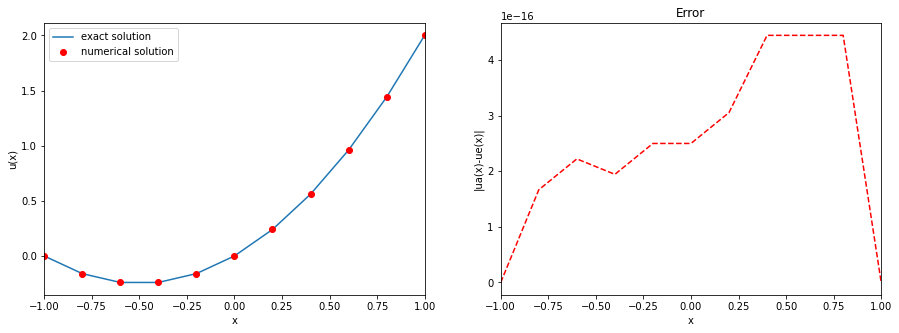

In [40]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(x,ue(x),label='exact solution')
ax1.plot(x,ua,'r o',label='numerical solution')
ax1.legend(loc='upper left')
ax1.set_xlim([-1,1])
ax1.set_ylabel('u(x)')
ax1.set_xlabel('x')

ax2.plot(x,np.abs(ua-ue(x)),'r--')
ax2.set_xlim([-1,1])
ax2.set_ylabel('|ua(x)-ue(x)|')
ax2.set_xlabel('x')
ax2.set_title('Error')
plt.show()